# Optimized Image Sampling for Explanations 

In [1]:
from __future__ import division
import os
import time
from glob import glob
import tensorflow as tf
from six.moves import xrange

import math
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import time as ti
import csv
#import matplotlib
#matplotlib.use('Agg')
import matplotlib.pyplot as plt
# from pympler import asizeof
import time as ti
from PIL import Image
import scipy.misc
import imageio
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

Using TensorFlow backend.


In [129]:
image_file_path = '/rhome/s7thakur/RISE/images/egycat2.jpg'
# mask_file_path = os.path.join('/rhome/s7thakur/RISE/inputs/masks/', 'importance_matrix_'+ '_'.join(os.path.basename(image_file_path).split('.')[0:-1]) +'.npy')
mask_file_path = os.path.join('/rhome/s7thakur/RISE/inputs/masks/importance_matrix_egycat2.npy')

# mask_file_path ='/rhome/s7thakur/RISE/inputs/masks/'

# mask_file_path ='/rhome/s7thakur/RISE/inputs/masks/'
model_path = '/rhome/s7thakur/image-completion-using-GANs/model/model_cats_dogs/'

In [2]:
image_file_path = '/rhome/s7thakur/RISE/images/church.jpg'
mask_file_path = os.path.join('/rhome/s7thakur/RISE/inputs/masks/', 'importance_matrix_church' +'.npy')
model_path = '/rhome/s7thakur/image-completion-using-GANs/model/model_imagenet_64/'

In [108]:
image_size = 64
image_shape = [image_size, image_size, 3]

In [4]:
img_width, img_height = 64, 64
# data_dir = '/home/s7thakur/RISE/'
learning_rate= 0.0002
beta1= 0.5
batch_size=64

In [5]:
alpha = 0.2
lambda_val = 0.005

In [6]:
def preprocessing(image):
    return image/127.5 - 1;

In [7]:
def lrelu(x,alpha):
    return tf.maximum(x, alpha*x)


# In[4]:

def linear(input_tensor, input_dim, output_dim, name=None):
    with tf.variable_scope(name):
        weights = tf.get_variable("weights", [input_dim, output_dim], initializer=tf.truncated_normal_initializer(stddev=math.sqrt(3.0 / (input_dim + output_dim))))
        bias = tf.get_variable("bias", [output_dim], initializer=tf.constant_initializer(0.0))
        return tf.matmul(input_tensor, weights) + bias 


# In[5]:

def conv_2d(input_tensor, input_dim, output_dim, name=None):
    with tf.variable_scope(name):
        kernel = tf.get_variable("kernel", [5, 5,input_dim, output_dim], initializer=tf.truncated_normal_initializer(stddev=0.02))
        bias = tf.get_variable("bias", [output_dim], initializer=tf.constant_initializer(0.0))
        conv = tf.nn.conv2d(input_tensor, kernel, strides=[1, 2, 2, 1],padding='SAME')
        return conv+bias


# In[6]:

def conv_2dtranspose(input_tensor, input_dim, output_shape,name=None):
    output_dim=output_shape[-1]
    with tf.variable_scope(name):
        kernel = tf.get_variable("kernel", [5, 5, output_dim, input_dim], initializer=tf.truncated_normal_initializer(stddev=0.02))
        bias = tf.get_variable("bias", [output_dim], initializer=tf.constant_initializer(0.0))
        deconv = tf.nn.conv2d_transpose(input_tensor, kernel, output_shape=output_shape, strides=[1, 2, 2, 1],padding='SAME')
        return deconv+bias


# In[7]:

def batch_norm(input_tensor,name,is_train=True):
    return tf.contrib.layers.batch_norm(input_tensor,decay=0.9, updates_collections=None, epsilon=1e-5, scale=True,    
                                        is_training=is_train, scope=name)


In [8]:
def generator(z):
#    z = tf.placeholder(tf.float32, [None, 100], name='z')
    l1=linear(input_tensor=z,name="g_lin", input_dim=100, output_dim=1024*4*4)  
    l2= tf.reshape(l1, [-1, 4, 4, 1024])
    l3 = tf.nn.relu(batch_norm(input_tensor=l2,name="g_bn0"))
    print(l3)
    #conv1
    l4=conv_2dtranspose(input_tensor=l3,name="g_c2dt1",input_dim=1024,output_shape=[batch_size,8,8,512])
    l5=tf.nn.relu(batch_norm(input_tensor=l4,name="g_bn1"))
    print(l5)
    #conv2
    l6=conv_2dtranspose(input_tensor=l5,name="g_c2dt2",input_dim=512,output_shape=[batch_size,16,16,256])
    l7=tf.nn.relu(batch_norm(input_tensor=l6,name='g_bn2'))
    print(l7)
    #conv3
    l8=conv_2dtranspose(input_tensor=l7,name='g_c2dt3',input_dim=256,output_shape=[batch_size,32,32,128])
    l9=tf.nn.relu(batch_norm(input_tensor=l8,name='g_bn3'))
    print(l9)
    #conv4
    l10=conv_2dtranspose(input_tensor=l9,name='g_c2dt4',input_dim=128,output_shape=[batch_size,64,64,3])
    l11=tf.nn.tanh(l10)
    print(l11)
    return l11

In [9]:
def discriminator(images, reuse=False, alpha=0.2):
     with tf.variable_scope("discriminator") as scope:
        if reuse:
            scope.reuse_variables()
            
        #naming of the layers is as per layer number    
        #h0 conv2d no batch_norm
        l1 = conv_2d(input_tensor=images, input_dim=3, output_dim= 64, name='d_c2d0')
        l2 = lrelu(l1,alpha)

        #h1 conv2d with batch_norm
        l3 = conv_2d(input_tensor=l2, input_dim=64, output_dim=64*2, name='d_c2d1')
        l4 = batch_norm(input_tensor=l3,name="d_bn1")
        l5 = lrelu(l4,alpha)

        #h2 conv2d with batch_norm
        l6 = conv_2d(input_tensor=l5, input_dim=64*2, output_dim=64*4, name='d_c2d2')
        l7 = batch_norm(input_tensor=l6,name="d_bn2")
        l8 = lrelu(l7,alpha)

        #h3 conv2d with batch_norm
        l9 = conv_2d(input_tensor=l8, input_dim=64*4, output_dim=64*8, name='d_c2d3')
        l10 = batch_norm(input_tensor=l9,name="d_bn3")
        l11 = lrelu(l10,alpha)

        #h4 reshape and linear
        l12 = tf.reshape(l11, [-1, 8192]) #l12 = tf.reshape(l11, [32, -1]) #l12 = tf.reshape(l11, [64, -1])
        l13 = linear(input_tensor=l12, input_dim=8192, output_dim=1, name="d_lin4")
        print(l13.get_shape().as_list())
        #sigmoid
        l14 = tf.nn.sigmoid(l13)
        print(l14)
        return l14, l13

In [10]:
z = tf.placeholder(tf.float32, [None, 100], name='z')
G = generator(z)

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

Tensor("Relu:0", shape=(?, 4, 4, 1024), dtype=float32)
Tensor("Relu_1:0", shape=(64, 8, 8, 512), dtype=float32)
Tensor("Relu_2:0", shape=(64, 16, 16, 256), dtype=float32)
Tensor("Relu_3:0", shape=(64, 32, 32, 128), dtype=float32)
Tensor("Tanh:0", shape=(64, 64, 64, 3), dtype=float32)


In [11]:
images = tf.placeholder(
            tf.float32, [None] + image_shape, name='real_images')

In [12]:
D1, D1_logits = discriminator(images, False, alpha)

[None, 1]
Tensor("discriminator/Sigmoid:0", shape=(?, 1), dtype=float32)


In [13]:
D2, D2_logits = discriminator(G, True, alpha)

[64, 1]
Tensor("discriminator_1/Sigmoid:0", shape=(64, 1), dtype=float32)


In [14]:
t_vars=tf.trainable_variables()
discrim_vars = [var for var in t_vars if 'd_' in var.name]
gen_vars = [var for var in t_vars if 'g_' in var.name]

In [15]:
discrim_loss_real_img = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=D1_logits, labels=tf.scalar_mul(0.9,tf.ones_like(D1_logits))))
discrim_loss_fake_img = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=D2_logits, labels=tf.zeros_like(D2_logits)))
discrim_loss = discrim_loss_real_img + discrim_loss_fake_img
gen_loss = tf.reduce_mean( tf.nn.sigmoid_cross_entropy_with_logits(logits=D2_logits, labels=tf.ones_like(D2_logits)))

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [16]:

dopt = tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=beta1).minimize(discrim_loss, var_list=discrim_vars)
gopt = tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=beta1).minimize(gen_loss, var_list=gen_vars)

In [17]:
saver = tf.train.Saver()

In [18]:
def load(checkpoint_dir):
    print(" [*] Reading checkpoints...")

    ckpt = tf.train.get_checkpoint_state(checkpoint_dir)
    if ckpt and ckpt.model_checkpoint_path:
        saver.restore(sess, ckpt.model_checkpoint_path)
        return True
    else:
        return False

In [19]:
sess = tf.InteractiveSession()
# sess.close()
isLoaded = load(model_path)

 [*] Reading checkpoints...
INFO:tensorflow:Restoring parameters from /rhome/s7thakur/image-completion-using-GANs/model/model_imagenet_64/saved_model_imagenet.ckpt


In [20]:
isLoaded

True

In [21]:
mask = tf.placeholder(tf.float32, [None] + image_shape, name='mask')

In [22]:
imp_matrix = tf.placeholder(tf.float32, [None] + image_shape, name='imp_matrix')

In [23]:
contextual_loss = tf.reduce_sum(
    tf.contrib.layers.flatten(
        tf.multiply(tf.abs(tf.multiply(tf.cast(mask,tf.float32), tf.cast(G,tf.float32)) - tf.multiply(tf.cast(mask,tf.float32), tf.cast(images, tf.float32))),tf.cast(imp_matrix, tf.float32))), 1)

Instructions for updating:
Use keras.layers.flatten instead.
Instructions for updating:
Please use `layer.__call__` method instead.


In [24]:
contextual_loss

<tf.Tensor 'Sum:0' shape=(64,) dtype=float32>

In [25]:
perceptual_loss = gen_loss
complete_loss = contextual_loss + lambda_val*perceptual_loss
grad_complete_loss = tf.gradients(complete_loss, z)

In [26]:
from keras.applications.resnet50 import ResNet50, preprocess_input, decode_predictions
from keras.preprocessing import image
def load_img(path):
    img = image.load_img(path, target_size=image_shape)
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    return img, x

def preprocessing(image):
    return image/127.5 - 1;

In [81]:
#get input image y
# real_images=next(img_input)
real_image = Image.open(image_file_path)
# img, real_images = load_img(image_file_path) 

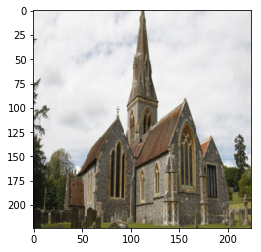

In [83]:
real_image = real_image.resize((64,64), Image.BILINEAR)
# real_image = real_image.resize((224,224), Image.BILINEAR)
plt.imshow(real_image)
real_image = np.asarray(real_image)
real_image = preprocessing(real_image)


In [84]:
 real_image.shape

(224, 224, 3)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


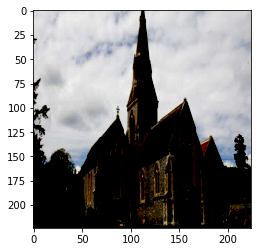

In [85]:
plt.figure()
plt.imshow(real_image)

In [86]:
real_images = batch_size*[real_image]

In [87]:
batch_images = np.array(real_images)


In [88]:
def create3ChannelMask(x):
    """Helper function, repeats single channel mask to 3 channels"""
    assert(len(x.shape)==2)
    return np.repeat(x[:,:,np.newaxis], 3, axis=2)

In [89]:
batch_images[0].shape

(224, 224, 3)

In [90]:
config = {}

In [91]:
config['maskType'] = 'custom'
config['learning_rate'] = 0.01
config['momentum'] = 0.9

In [92]:
importance_matrix = np.load(mask_file_path, allow_pickle=True)
# print(importance_matrix)
importance_matrix = importance_matrix.item().get('mask_0.0')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


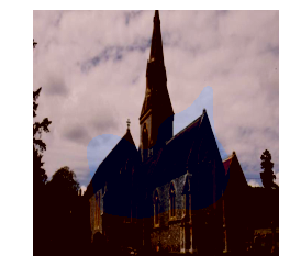

In [93]:
plt.figure()
plt.imshow(real_image)
plt.imshow(importance_matrix, cmap='jet', alpha=0.2)
plt.tight_layout()
plt.axis('off')
plt.savefig('relevance_mask_church.png', transparent=True,bbox_inches='tight',pad_inches=0, dpi=300)

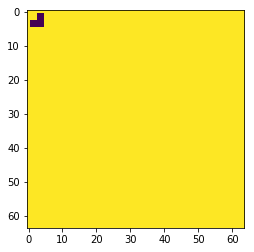

In [75]:
# resize the mask from 224x224 to 64x64
r,c = np.where(importance_matrix ==0)
r,c = [int(round(x)) for x in (r/224)*63], [int(round(x)) for x in (c/224)*63]
# print(r, c)
rescaled = np.ones((64,64))
rescaled[r,c] = 0
importance_matrix = rescaled
plt.figure()
plt.imshow(importance_matrix)

In [94]:
bmask = importance_matrix.copy()

In [95]:
from scipy.signal import convolve2d
nsize=15
ker = np.ones((nsize,nsize), dtype=np.float32)
ker = ker/np.sum(ker)
importance_matrix = importance_matrix*convolve2d(1-importance_matrix, ker, mode='same', boundary='symm')

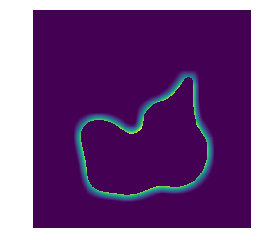

In [96]:
plt.figure()
plt.imshow(importance_matrix)
plt.axis('off')
plt.savefig('egycat2_relevance_mask.svg')

In [97]:
#get mask M
if config['maskType'] == 'random':
    fraction_masked = 0.2
    mask_ = np.ones(image_shape)
    mask_[np.random.random(image_shape[:2]) < fraction_masked] = 0.0
elif config['maskType'] == 'center':
    scale = 0.25
    #assert(scale <= 0.5)
    mask_ = np.ones(image_shape)
    sz = image_size
    l = int(image_size*scale)
    u = int(image_size*(1.0-scale))
    mask_[l:u, l:u, :] = 0.0
elif config['maskType'] == 'left':
    mask_ = np.ones(image_shape)
    c = image_size // 2
    mask_[:,:c,:] = 0.0
elif config['maskType'] == 'full':
    mask_ = np.ones(image_shape)
elif config['maskType'] == 'custom':
    mask_ = bmask
else:
    assert(False)

In [98]:
def merge(images, size):
    h, w = images.shape[1], images.shape[2]
    img = np.zeros((int(h * size[0]), int(w * size[1]), 3))
    x = 0.0
    y = 0.0
    for idx, image in enumerate(images):
        i = idx % size[1]
        j = idx // size[1]
        img[j*h:j*h+h, i*w:i*w+w, :] = image
        x = max(x, i*w+w)
        y = max(y, j*h+h)

    img = img[0:y, 0:x]
    print(x, y)
    return img

def save_images(images, size, image_path):
    return imageio.imwrite(inverse_transform(images), size, image_path)

def imsave(images, size, path):
    img = merge(images, size)
    return imageio.imwrite(path, (255*img).astype(np.uint8))

def inverse_transform(images):
    return (images+1.)/2.

In [99]:
config

{'learning_rate': 0.01, 'maskType': 'custom', 'momentum': 0.9}

In [100]:
mask_ = create3ChannelMask(mask_)
importance_matrix = create3ChannelMask(importance_matrix)

In [105]:
#batch_images = ...

# batch_mask = np.array(batch_size*[mask_]).astype(np.float32)
# imp_mask = np.array(batch_size*[importance_matrix]).astype(np.float32)

batch_mask = np.resize(mask_, [batch_size] + image_shape)
print(batch_mask.shape)
imp_mask = np.resize(importance_matrix, [batch_size] + image_shape)
print(imp_mask.shape, batch_images.shape)
zhats = np.random.uniform(-1, 1, size=(batch_size, 100))
outInterval=50
outDir="samples/"
vel = 0
masked_images = np.multiply(batch_images, batch_mask)
for i in xrange(1500):
    fd = {
        z: zhats,
        imp_matrix: imp_mask,
        mask: batch_mask,
        images: batch_images,
    }
    run = [complete_loss, grad_complete_loss, G]
    loss, g, G_imgs = sess.run(run, feed_dict=fd)
    
    if (i%500 is 0):
        print("loss in iteration: " + str(i) + " is: " + str(np.mean(loss)))

    prev_vel = np.copy(vel)
    vel = config['momentum']*vel - config['learning_rate']*g[0]
    zhats += -config['momentum'] * prev_vel + (1+config['momentum'])*vel
    zhats = np.clip(zhats, -1, 1)
    
#     if i % outInterval == 0:
                    
#                     inv_masked_hat_images = np.multiply(G_imgs, 1-batch_mask)
#                     completed = masked_images + inv_masked_hat_images
                    
#                     imgName = os.path.join(outDir,
#                                            '{:04d}.png'.format(i))
#                     save_images(completed, [8,8], imgName)
                    

(64, 224, 224, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


512 512


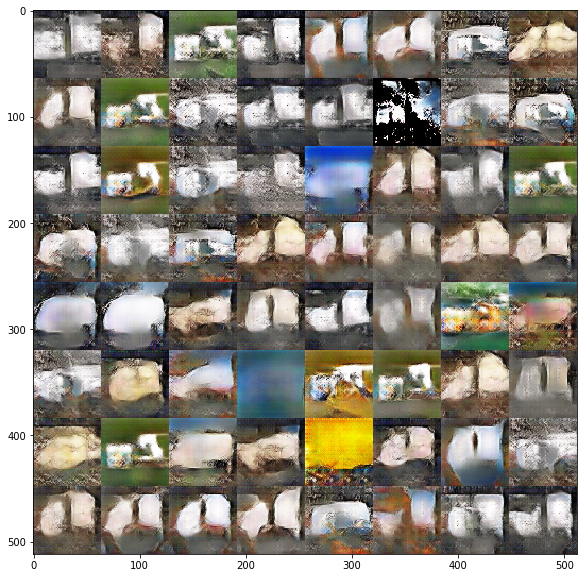

In [47]:
created_images = (G_imgs + 1.)/2
im = merge(created_images, [8,8])
plt.figure(figsize=(10,10))
plt.imshow(im)
plt.axis('on')
plt.show()

512 512


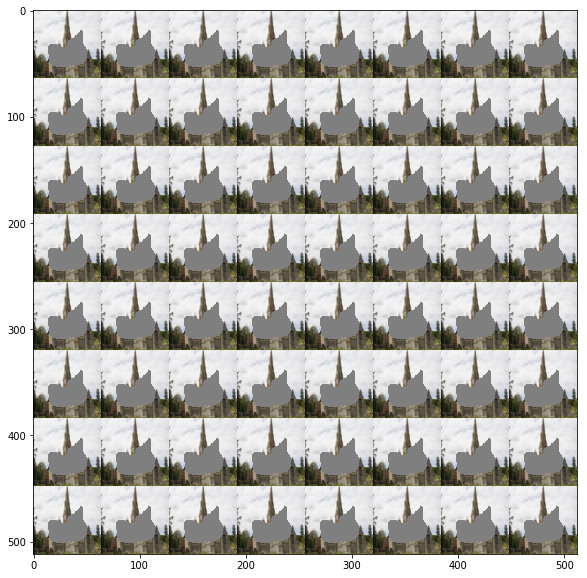

In [76]:

masked_images = np.multiply(batch_images, batch_mask)

input_images = (masked_images + 1.)/2

im = merge(input_images, [8,8])
plt.figure(figsize=(10,10))
plt.imshow(im)
plt.axis('on')
plt.show()

(224, 224, 3) (224, 224, 3)


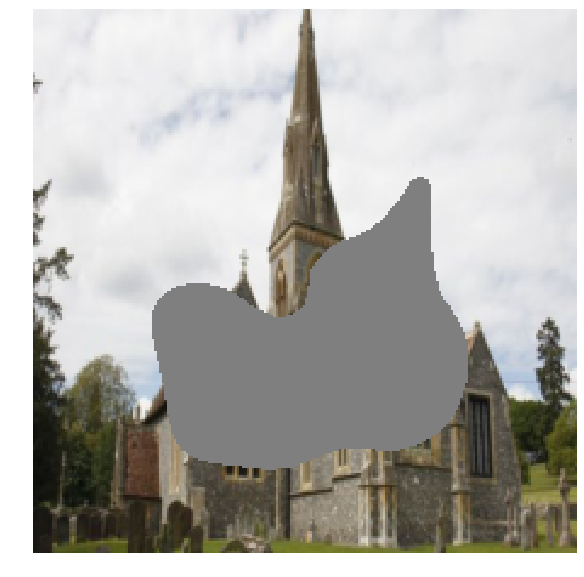

In [107]:
print(batch_images[0].shape, batch_mask[0].shape)
masked_images = np.multiply(batch_images[0], batch_mask[0])

input_images = (masked_images + 1.)/2

# im = merge(input_images, [8,8])
plt.figure(figsize=(10,10))
plt.imshow(input_images)
plt.axis('off')
plt.savefig('mask_church.png', transparent=True,bbox_inches='tight',pad_inches=0, dpi=300 )

plt.show()

In [49]:
inv_mask_ = 1- mask_

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


512 512


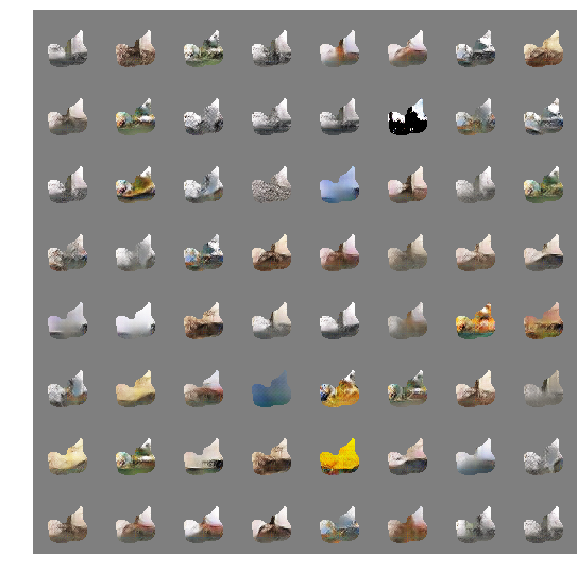

In [51]:
inv_batch_mask = np.resize(inv_mask_, [batch_size] + image_shape)
inv_masked_images = np.multiply(G_imgs, inv_batch_mask)

inv_input_images = (inv_masked_images + 1.)/2
im_ = merge(inv_input_images, [8,8])
plt.figure(figsize=(10,10))
plt.imshow(im_)
plt.axis('off')
plt.savefig('alternate_variations_church.png', transparent=True,bbox_inches='tight',pad_inches=0, dpi=300 )
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


512 512


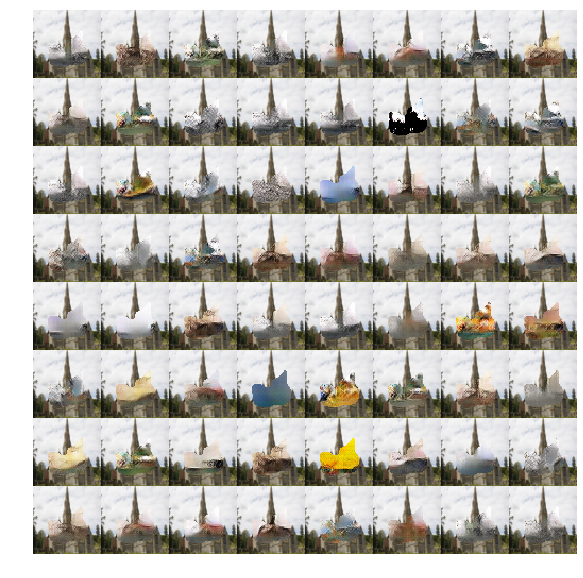

In [52]:
#RECONSTRUCTED IMAGES


inv_batch_mask = np.resize(inv_mask_, [batch_size] + image_shape)
inv_masked_images = np.multiply(G_imgs, inv_batch_mask)

Recons_img = inv_masked_images + masked_images

rec_images = (Recons_img + 1.)/2
im_r = merge(rec_images, [8,8])
plt.figure(figsize=(10,10))

plt.imshow(im_r)
plt.axis('off')
plt.savefig('completed_alternated_images_church.png', transparent=True,bbox_inches='tight',pad_inches=0, dpi=300)
plt.show()

In [178]:
np.save('persiancat_saliency_generation_0.05.npy', G_imgs)